README!

PROYECTO DE CIENCIA DE DATOS: Airbnb

1- Objetivo: Detectar anomalias en el precio de hospedajes disponibles en la plataforma Airbnb basado en la información declarada por el anfitrion y las revisiones de los usuarios.

2- Dataset: El dataset utilizado fue extraido de Inside Airbnb (https://insideairbnb.com/get-the-data/). Consta de 2 archivos en formato .csv, asociados a un id del hospedaje.

Archivo 1 - listings.csv.gz (80 MB):  contiene informacion del anuncio como, descripcion de la propiedad, precio, y datos del anfitrion, entre otros.  
Archivo 2 - reviews.csv.gz (260 MB):  contiene revisiones y comentarios de la expereiencia del usuarios.

3- Flujo de trabajo:

3.1. Se utilizó google colab como entorno de desarrollo.

3.2. Se subieron los datos a google Drive y desde google colab se generó un shortcut a los archivos.

3.3. Data wrangling (vizualizaciín, limpieza, estructuracion y enriquecimiento de los datos). Solo se aceptó un % maximo de pérdida de datos de 5%. Esto se logró mediante imputación (como en los baños con 0.5) y filtrado estratégico de nulos.

3.4. Se Vizualizaron los archivos, se analizaron las caracetrícas y se seleccionaron un grupo de ellas, como 'id', 'name' 'description', bedrooms, accommodates, bathrooms, entre otras de listings.csv y id, listing_id, commnets, de reviews.csv (ver apartado y ...)

3.5. Se identificaron precios anómalos o muy alejados de la realidad los cuales furon filtrados para precios de 15,000 a 400,000.

3.5. Se transformó la variable 'price' (target) de string a .float.

3.6. Extrayendo informacion de las variables de texto como 'name' y 'descriptions' y 'comments' se crearon y cruzaron info para crear nuevas variables categóricas, como: el depto tiene o no espacio abierto privado, score de cocina, score de quejas, etc. Se realizaron algunos graficos representativos barchart y burbujas. El análisis fue bilingue.

3.7 Se generó un dataframe maestro 'df_master()' con las caracetisticas mas importante y generamos una matriz de correlación para ver las caracteristicas que mas afectan al precio.

3.8. Se entrenó un modelo de random forest para auditar y predecir el precio correcto en base a sus caraceristicas.

Métricas:

R^2=0.49,

MAE \approx = 16,000

3.9. Se auditó el modelo para determintar la diferencia entre el valor predicho y el valor real publicado en 10 hospedajes con valores muy elevados. Las diferencias fueron muy grandes entre 150,000 y 300,000. Limitación del modelo o 'especulación inmobiliaria'?

3.10. Se creó una funcion de tasación de hospedajes para determinar el precio predicho por el modelo en base a las features importance.

3.11. Conclusiones finales


3. Flujo de trabajo

   3.1. Preparación del entorno de desarrollo: Google colab --> jupyter notebook
   
   3.2. Datasets

In [1]:
# Shortcut a archivos en google drive
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')



Mounted at /content/drive


3.3 Data wrangling

3.4 Vizualización y selección de features para listings.csv

In [2]:
# Leer los archivos.csv usando pandas
import pandas as pd

# Definimos las columnas que nos interesan para el estudio
# del archivo listings.csv.gz

columnas_interes_list = ['id', 'listing_url', 'name', 'description', 'neighbourhood_cleansed',
                         'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
                         'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
                         'number_of_reviews', 'review_scores_rating', 'review_scores_location']

df_listings = pd.read_csv('/content/drive/MyDrive/Row_Data_Airbnb/listings.csv.gz', usecols=columnas_interes_list)

# imprimir 5 datos al azar
# se puede usar print(df.sample(5), 'random_state = 42')
# para mantener los 5 datos cada vez que se ejecuta la celda

print(df_listings.head(5))   # alternativa ***print(df.sample())***

      id                         listing_url  \
0  11508  https://www.airbnb.com/rooms/11508   
1  14222  https://www.airbnb.com/rooms/14222   
2  15074  https://www.airbnb.com/rooms/15074   
3  16695  https://www.airbnb.com/rooms/16695   
4  20062  https://www.airbnb.com/rooms/20062   

                                               name  \
0                Amazing Luxurious Apt-Palermo Soho   
1      RELAX IN HAPPY HOUSE - PALERMO, BUENOS AIRES   
2                             ROOM WITH RIVER SIGHT   
3                         DUPLEX LOFT 2 - SAN TELMO   
4  PENTHOUSE /Terrace & pool /City views /2bedrooms   

                                         description neighbourhood_cleansed  \
0  LUXURIOUS 1 BDRM APT- POOL/ GYM/ 24-HR SECURIT...                Palermo   
1  Beautiful cozy apartment in excellent location...                Palermo   
2                                                NaN                  Nuñez   
3                                                NaN            

3.4 Vizualización y selección de features para reviews.csv

In [3]:
# Definimos las columnas que nos interesan para el estudio
# del archivo reviews.csv.gz

columnas_interes_rev = ['listing_id', 'id', 'comments']

df_reviews = pd.read_csv('/content/drive/MyDrive/Row_Data_Airbnb/reviews.csv.gz', usecols=columnas_interes_rev)
print(df_reviews.sample(5))

                 listing_id                   id  \
290697             29510716   995663708356192718   
504590             53398498  1037011026463420866   
958940  1170524986661117582  1210169985575773109   
118878             10365022            170985107   
638692   741159192041999937   861629352243873013   

                                                 comments  
290697  Excelente lugar, cumple con todo lo dicho en l...  
504590                              Everything was great!  
958940  Nos encantó el depto. Super limpio y organizad...  
118878  Vicky siempre estaba pendiente de nosotras dis...  
638692  Todo funcionó según lo pactado. Buena ubicació...  


3.5. Actualizamos el valor de precio de string a número

In [4]:
# Actualizamos el valor de precio de string a número
# 'price' será nuestra variable 'target'

# Quitar el signo $ y las comas (usando regex=False para que busque los caracteres)
df_listings['price'] = df_listings['price'].str.replace('$', '', regex=False).str.replace(',', '')
# --------------------- Dentro del df ubica la columna 'price'.
# ------------------------------------------ considera sus valores como strings
#------------------------------------------------ Reemplaza '$' como espacio vacio ''.
#----------------------------------------------------------------- Lietralmente $ es un símbolo peso.
#-------------------------------------------------------------------------------- Ahora reemplaza ',' por ''.
# Convertir a float
df_listings['price'] = df_listings['price'].astype(float)

# Verificar con describe para ver promedio y máximos
print(df_listings['price'].describe())

count    3.159800e+04
mean     9.548776e+04
std      1.402656e+06
min      2.600000e+02
25%      2.971100e+04
50%      3.990800e+04
75%      5.776200e+04
max      1.050217e+08
Name: price, dtype: float64


Conclusión: la columna 'price' muestra valores anómalos muy alejados de la realidad (valores mal cargados, inflación de precio para no alquilar, etc etc)

3.5. Se aplicó un filtro de precios para valores > 15,000 y < 400,000 mil pesos. Mas alineados con la realidad.

In [5]:
# Filtramos para quedarnos con lo que parece real (ejemplo entre 15.000 y 400.000 pesos)
#En el análisis con .describe() anterior, se ven valores absurdos.
#Para tener buenos datos nos quedaremos con todas las filas
#que tengan un valor de 'precio' >15000 (depto mas barato)
#y <400,000 (deptos mas caros).

df_listings = df_listings[(df_listings['price'] > 15000) & (df_listings['price'] < 400000)]

print(f"Luego de limpiar outliers nos quedan {len(df_listings)} filas.")
print(df_listings['price'].describe().round(2))

Luego de limpiar outliers nos quedan 30719 filas.
count     30719.00
mean      51761.97
std       39336.09
min       15008.00
25%       30456.00
50%       40000.00
75%       57762.00
max      399082.00
Name: price, dtype: float64


Observación: El dataset se reconfigura de 31,598 registros de 'hospedajes' a 30,719 registros.

In [6]:
df_listings.describe().round(2)

,id,latitude,longitude,accommodates,bedrooms,beds,price,number_of_reviews,review_scores_rating,review_scores_location
count,3.071900e+04,30719.00,30719.00,30719.00,30686.00,30710.00,30719.00,30719.00,26542.00,26542.00
mean,7.356085e+17,-34.59,-58.42,2.96,1.15,1.89,51761.97,30.16,4.79,4.87
std,4.779430e+17,0.02,0.03,1.45,0.85,1.45,39336.09,46.77,0.35,0.25
min,1.150800e+04,-34.68,-58.53,1.00,0.00,0.00,15008.00,0.00,0.00,1.00
25%,5.244702e+07,-34.60,-58.44,2.00,1.00,1.00,30456.00,3.00,4.73,4.85
50%,9.064236e+17,-34.59,-58.42,2.00,1.00,1.00,40000.00,13.00,4.88,4.94
75%,1.105710e+18,-34.58,-58.39,4.00,1.00,2.00,57762.00,39.00,5.00,5.00
max,1.344330e+18,-34.53,-58.36,16.00,31.00,36.00,399082.00,992.00,5.00,5.00


3.6. Flagging: Se extrajo informaciónn de las variables de texto como 'name', 'descriptions' y 'comments'. Las mismas se utilizaron para crear y cruzar info en nuevas variables categóricas.

Comentario: Se consideró la diversidad de idiomas aunque los que mas dominan son inglés y español.

3.6.1. Identificación de palabras clave en 'descriptions' (balcón, balcon, balcony, terrace, etc.)

In [7]:
# El dataset de Airbnb no tiene columnas para indicar si un depto
#tiene o no balcón y cuantos blacones tiene (Puede el balcón
#inflar el precio????)
# Una estrategia, es extraer esa información desde la columna
# 'descriptions'

# Se puede usar la técnica llamada 'flagging' para crear
#columnas de 0 o 1.

# Los dataset pueden mezclar distintas lenguas inglés y español
# por ejemplo, para balcón podriamos encontrar:
# 'balcon|balcón|balcony|terrace|terraza|deck'

# Buscamos la raíz 'balcon' (español) O 'balcony' (inglés)
# Agregamos 'deck' o 'terrace' que también mencionaste que te interesan
tipo_de_espacio_abierto = 'balcon|balcón|balcony|terrace|terraza|deck'

df_listings['tiene_espacio_abierto'] = df_listings['description'].str.contains(tipo_de_espacio_abierto, case=False, na=False).astype(int)

# Ahora verifiquemos de nuevo el conteo
print(df_listings['tiene_espacio_abierto'].value_counts())


tiene_espacio_abierto
0    22574
1     8145
Name: count, dtype: int64


3.6.1 Chequeo de que Pandas esta identificando las palabras 'clave' correctas en 'descriptions' para diferenciar en hospedaje con espacio abierto o no.

In [8]:
# Esto le dice a Pandas que no corte el texto en las columnas
pd.set_option('display.max_colwidth', None)

# Vamos a ver 10 ejemplos donde el código dijo que SI hay espacio abierto
print("--- CHEQUEO DE POSITIVOS (Deberían tener balcón) ---")
print(df_listings[df_listings['tiene_espacio_abierto'] == 1]['description'].sample(10))

# Vamos a ver 10 ejemplos donde el código dijo que NO hay
print("\n--- CHEQUEO DE NEGATIVOS (No deberían mencionar balcón) ---")
print(df_listings[df_listings['tiene_espacio_abierto'] == 0]['description'].sample(10))

--- CHEQUEO DE POSITIVOS (Deberían tener balcón) ---
16553                                         PENT HOUSE at the heart of VILLA URQUIZA. Enjoy your stay and disconnect from your worries in this spacious space, with its own terrace and open view. Modern, cozy, family-friendly design, all to be brand new, fully equipped so you don't lack anything in your stay. Enjoy the outdoors or a comfortable living room with the best "Dolce Gusto" capsule coffee that will be at your disposal. With the unparalleled tranquility and comfort of having your garage downstairs.
31383                                                                                                                              This 2 room apartment in Núñez is a true treasure. It features a spectacular balcony that offers an open view, perfect for enjoying the outdoors. The bedroom is spacious and bright, with windows that let in plenty of natural light, creating a cozy atmosphere. The apartment is ready for you to enjoy it

Conclusión: concluimos que el anfitrion no siempre menciona los espacios abiertos disponibles en las 'descriptions' del hospedaje.

3.6.2. Identificación de palabras clave en 'amenities' (balcón, balcon, balcony, terrace, etc.)

In [9]:
# Buscamos en amenities (que suele estar en inglés)
patron_amenities = 'Patio or balcony|Backyard'

# Creamos la bandera basada en amenities
df_listings['balcon_amenities'] = df_listings['amenities'].str.contains(patron_amenities, case=False, na=False).astype(int)

# Creamos la columna DEFINITIVA: 1 si está en descripción O en amenities
df_listings['balcon_final'] = ((df_listings['tiene_espacio_abierto'] == 1) | (df_listings['balcon_amenities'] == 1)).astype(int)

# Veamos cómo cambiaron los números
print("Conteo final consolidado:")
print(df_listings['balcon_final'].value_counts())

Conteo final consolidado:
balcon_final
1    18906
0    11813
Name: count, dtype: int64


Concluimos que 'amenities' es mas confiable para identificar si un hospedaje tiene o no espacios abiertos

3.6.3. Creamos las primeras features 'es_privado' = tiene espacio abierto privado y 'es_comun' = tiene espacio comun no privado

In [10]:
# 1. Definimos las listas de palabras clave
keywords_privado = 'balcon|balcón|balcony|pátio privado|private patio|balcon-terraza'
keywords_comun = 'solarium|deck|piscina|pool|sum|shared terrace|terraza compartida|garden|jardín|parrilla'

# 2. Buscamos en 'description' y 'amenities' combinados para cada categoría
df_listings['info_total'] = df_listings['description'].fillna('') + " " + df_listings['amenities'].fillna('')

df_listings['es_privado'] = df_listings['info_total'].str.contains(keywords_privado, case=False, na=False).astype(int)
df_listings['es_comun'] = df_listings['info_total'].str.contains(keywords_comun, case=False, na=False).astype(int)

print(len(df_listings))

# 3. Analicemos el cruce
print("Tabla cruzada de espacios:")
print(pd.crosstab(df_listings['es_privado'], df_listings['es_comun']))

30719
Tabla cruzada de espacios:
es_comun        0     1
es_privado             
0           10336  2881
1           10154  7348


Conclusiones:

a. Hay más de 10.000 departamentos (el 33%) que no tienen ni espacio privado (balcón) ni espacios comunes (pileta/terraza). Estos son, probablemente, los monoambientes céntricos o edificios antiguos.

b. Casi un 24% de la oferta tiene ambos. Estos suelen ser los edificios nuevos (o renovados) en zonas como Palermo, Belgrano o Caballito, que ofrecen el balcón propio más los amenities del edificio. Aquí es donde seguramente encontraremos los precios más altos.

c. 10.154 deptos tienen balcón privado pero el edificio no ofrece nada común (clásico edificio de departamentos estándar de Buenos Aires).

d. Solo 2.881 deptos tienen amenities comunes pero no tienen balcón privado. Estos podrian ser una mezcla de distintos edificios donde se priorizan areas comunes abiertas sobre privadas.



3.6.4. Vizualizamos review.csv, creamos la columna 'comments' utilizando .dropna() y .groupby() y la adicionamos al df creado de listings.csv. Obtenemos el df maestro 'df_master[]'

In [11]:
# 1. Leemos el archivo de reviews (solo las columnas necesarias)
# Nota: cámbialo a .csv.gz si sigue comprimido
df_reviews = pd.read_csv('/content/drive/MyDrive/Row_Data_Airbnb/reviews.csv.gz', usecols=['listing_id', 'comments'])

# 2. Limpieza rápida: quitar reviews vacías
df_reviews = df_reviews.dropna(subset=['comments'])

# 3. Agrupamos las reviews por departamento para tener un "gran texto" de opiniones por cada uno
# Esto puede demorar un poquito si hay muchas reviews
df_reviews_agg = df_reviews.groupby('listing_id')['comments'].apply(lambda x: ' '.join(x)).reset_index()

# 4. Unimos con nuestro dataframe principal
df_master = pd.merge(df_listings, df_reviews_agg, left_on='id', right_on='listing_id', how='left')

print(f"Ahora tenemos un dataset maestro con {df_master.shape[0]} filas y comentarios integrados.")

Ahora tenemos un dataset maestro con 30719 filas y comentarios integrados.


3.6.5. Cruzamos info de 'descriptions' y 'comments' y hacemos flagging para crear variables categóricas (0, 1) como 'posible_enganio', 'dice_lujo', etc.

In [12]:
# 1. Buscamos si el anfitrión dice "Lujo" o "Luxury" en la descripción
df_master['dice_lujo'] = df_master['description'].str.contains('lujo|luxury|premium|amazing', case=False, na=False).astype(int)

# 2. Buscamos si los huéspedes dicen "pequeño", "chico" o "small" en los comentarios
# (Usamos los comentarios agrupados que acabas de unir)
df_master['queja_espacio'] = df_master['comments'].str.contains('pequeño|chico|small|tiny|tight', case=False, na=False).astype(int)

# 3. Identificamos la "Contradicción"
# Es de lujo (según dueño) PERO es chico (según gente)
df_master['posible_enganio'] = ((df_master['dice_lujo'] == 1) & (df_master['queja_espacio'] == 1)).astype(int)

print(f"Detectamos {df_master['posible_enganio'].sum()} departamentos con posibles descripciones engañosas sobre el espacio.")

Detectamos 629 departamentos con posibles descripciones engañosas sobre el espacio.


3.6.6. Extraemos info de 'comments' y hacemos flagging para crear variables categóricas (0, 1) como 'falla_mantenimiento', 'falla_clima', etc.

In [13]:
# Definimos los patrones bilingües
# Mantenimiento
quejas_mantenimiento = 'mal olor|malos olores|smell|stink|griferia rota|perdia agua|broken faucet|broken tap|broken|rota|roto|inundaba|inundó|flooded|leak|perdia|perdía'

# Climatización
quejas_climatizacion = 'aire no enfriaba|cold apartment| cold bedroom|no funcionaba el aire|ac not working|no air conditioning|too cold|no calentaba|no enfriaba|mucho calor|mucho frio|stuffy'

# Veracidad (El núcleo de tu sospecha)
quejas_veracidad = 'distinto a las fotos|different from photos|misleading|engañoso|fake|not as pictured|photos are old'

# Ejecutamos la búsqueda bilingüe
df_master['falla_mantenimiento'] = df_master['comments'].str.contains(quejas_mantenimiento, case=False, na=False).astype(int)
df_master['falla_clima'] = df_master['comments'].str.contains(quejas_climatizacion, case=False, na=False).astype(int)
df_master['falla_veracidad'] = df_master['comments'].str.contains(quejas_veracidad, case=False, na=False).astype(int)

In [14]:
print(f"Detectamos {df_master['falla_mantenimiento'].sum()} con falla de mantenimiento,"
      f" {df_master['falla_clima'].sum()} con falla en el acondicionamiento de la temperatura y"
      f" {df_master['falla_veracidad'].sum()} con falla en la veracidad del anuncio")

Detectamos 3757 con falla de mantenimiento, 695 con falla en el acondicionamiento de la temperatura y 99 con falla en la veracidad del anuncio


3.6.7. Creamos un score de quejas (0, 1, 2, 3) y creamos la variable = 'total_quejas'. también determinamos si el numero de quejas afecta el precio promedio del hospedaje

In [15]:
# Creamos una columna que sume todas las fallas detectadas
df_master['total_quejas'] = df_master['falla_mantenimiento'] + df_master['falla_clima'] + df_master['falla_veracidad']

# Comparamos el precio promedio de los "Sanos" vs los "Con Quejas"
print("Precio promedio según nivel de quejas:")
print(df_master.groupby('total_quejas')['price'].mean())

Precio promedio según nivel de quejas:
total_quejas
0    51639.157907
1    52226.821447
2    56358.662252
3    57361.428571
Name: price, dtype: float64


Conclusión: El número de quejas no afecta el promedio del precio por hospedaje. Se observa, que a mayor quejas mayor el precio promedio. Un huesped si paga mas puede ser mas exigente.

3.6.8. Identificamos algunos casos de precios altos con muchas quejas.

In [16]:
# Filtramos los que tienen el máximo nivel de quejas (3)
# Y que además el dueño usó palabras como 'lujo', 'amazing' o 'luxury'
vendedores_humo = df_master[(df_master['total_quejas'] >= 2) & (df_master['dice_lujo'] == 1)]

# Ordenamos por precio para ver los más caros primero
vendedores_humo = vendedores_humo.sort_values(by='price', ascending=False)

# Mostramos el nombre, el barrio, el precio y el link para investigar
print("LOS TOP VENDEDORES DE HUMO (Caros, 'Lujosos' y con Quejas):")
print(vendedores_humo[['name', 'neighbourhood_cleansed', 'price', 'listing_url']].head(5))

LOS TOP VENDEDORES DE HUMO (Caros, 'Lujosos' y con Quejas):
                                                     name  \
10400   Exclusive 2-floor penthouse in beautiful Recoleta   
157                      Casabierta, style in Palermo BA.   
500                   Stunning 2bd in lovely Palermo Soho   
1440   Amazing view - duplex pool gym and more in Palermo   
7247                  Premium 1BR steps away from Palermo   

      neighbourhood_cleansed     price  \
10400               Recoleta  210043.0   
157                  Palermo  199541.0   
500                  Palermo  161733.0   
1440                 Palermo   99466.0   
7247                 Palermo   93469.0   

                                           listing_url  
10400  https://www.airbnb.com/rooms/711686038066377288  
157                https://www.airbnb.com/rooms/476044  
500               https://www.airbnb.com/rooms/1542874  
1440              https://www.airbnb.com/rooms/9355275  
7247             https://www.airbnb

In [17]:
print(df_master.head())

      id                         listing_url  \
0  11508  https://www.airbnb.com/rooms/11508   
1  14222  https://www.airbnb.com/rooms/14222   
2  16695  https://www.airbnb.com/rooms/16695   
3  20062  https://www.airbnb.com/rooms/20062   
4  65446  https://www.airbnb.com/rooms/65446   

                                               name  \
0                Amazing Luxurious Apt-Palermo Soho   
1      RELAX IN HAPPY HOUSE - PALERMO, BUENOS AIRES   
2                         DUPLEX LOFT 2 - SAN TELMO   
3  PENTHOUSE /Terrace & pool /City views /2bedrooms   
4              Premier Loft with Breathtaking Views   

                                                                                                                                                                                                                                                                                                                                                                                            

3.6.9. Creamos un score de cocina usando palabras claves para identificar en 'amenities'. Creamos la variable 'score_cocina'

In [18]:
import re
# Elementos clave de una cocina real
elementos_cocina = 'oven|horno|stove|hornalla|cooktop|refrigerator|heladera|coffee maker|cafetera|microwave|microondas'

# Creamos el score contando cuántos de estos elementos aparecen en amenities
df_master['score_cocina'] = df_master['amenities'].str.count(elementos_cocina, flags=re.IGNORECASE)

# Normalizamos para que no haya errores si no hay amenities
df_master['score_cocina'] = df_master['score_cocina'].fillna(0)

In [19]:
# Fórmula simplificada:
# (Servicios + 1) / (Quejas + 1) * (Precio Promedio del Barrio / Precio del Depto)

# Calculamos el precio promedio por barrio para comparar
precio_medio_barrio = df_master.groupby('neighbourhood_cleansed')['price'].transform('mean')

df_master['calidad_precio_score'] = (
    (df_master['score_cocina'] + df_master['es_privado'] + 1) /
    (df_master['total_quejas'] + 1)
) * (precio_medio_barrio / df_master['price'])

3.6.10. Identificamos el top 10 de barrios con mas quejas.

/tmp/ipython-input-538188846.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=peligro_barrios.index, y=peligro_barrios['total_quejas'], palette='Reds_r')


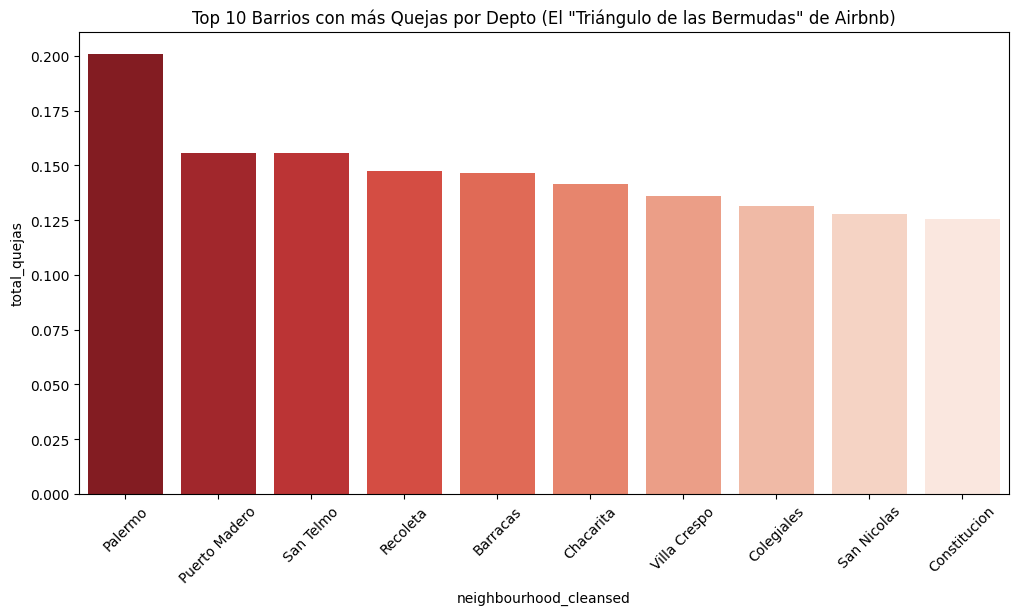

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Agrupamos por barrio para ver dónde están los "Vendedores de Humo"
# Definimos "Peligro" como barrios con muchas quejas y mucho índice de exageración
peligro_barrios = df_master.groupby('neighbourhood_cleansed').agg({
    'total_quejas': 'mean',
    'dice_lujo': 'mean',
    'price': 'mean'
}).sort_values(by='total_quejas', ascending=False).head(10)

# Graficamos
plt.figure(figsize=(12,6))
sns.barplot(x=peligro_barrios.index, y=peligro_barrios['total_quejas'], palette='Reds_r')
plt.xticks(rotation=45)
plt.title('Top 10 Barrios con más Quejas por Depto (El "Triángulo de las Bermudas" de Airbnb)')
plt.show()

Conclusiones:

a. El Fenómeno Palermo (El #1 del Riesgo)

Palermo es el barrio con más oferta. Hay muchísimos edificios de "diseño" construidos rápido y con materiales modernos pero a veces de baja calidad (paredes de durlock, aires acondicionados que no dan abasto para tanto vidrio).

La trampa: Es el barrio más "scrolleado". Los anfitriones usan palabras como Amazing, Stunning y Chic para destacar entre 10.000 opciones.

Resultado: Mucha expectativa + construcción moderna deficiente = Quejas.

b. Puerto Madero (La Paradoja del Lujo)

Este es el hallazgo más interesante del proyecto. En Puerto Madero los precios son astronómicos.

El factor "Exigencia": Si alguien paga $300.000 por noche, no perdona que la cafetera sea vieja o que el check-in se retrase 10 minutos.

El factor "Vacío": Muchos departamentos son inversiones que están vacíos meses. Cuando alguien entra, las cañerías tienen olor o el aire no se prendió en meses. El huésped siente que pagó por un hotel 5 estrellas y recibió un departamento frío.

c. San Telmo y Recoleta (Propiedades "Vintage")

San Telmo suele tener el problema de la humedad y la infraestructura antigua, pero quizás los precios son un poco más honestos que en Palermo, por eso quedó tercero.

3.6.11. Graficamos el Precio vs. Quejas y coloreamos por  calidad_precio_score.

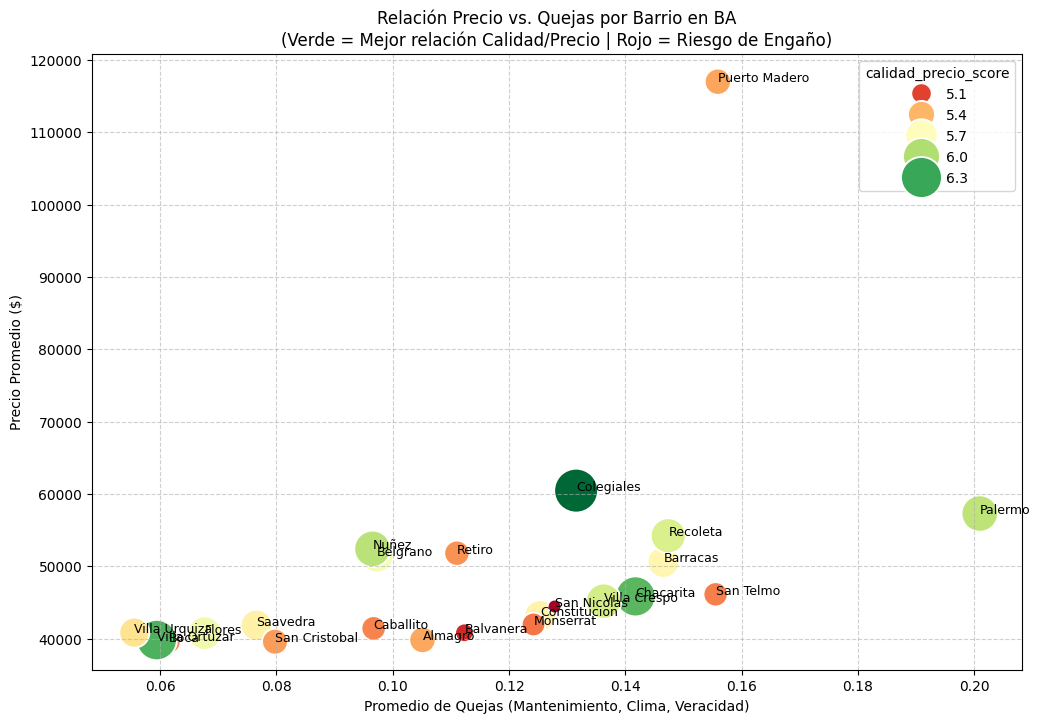

In [21]:
plt.figure(figsize=(12, 8))

# Filtramos barrios con un mínimo de departamentos para que el promedio sea real
barrios_principales = df_master['neighbourhood_cleansed'].value_counts()[df_master['neighbourhood_cleansed'].value_counts() > 100].index
df_plot = df_master[df_master['neighbourhood_cleansed'].isin(barrios_principales)]

# Agrupamos por barrio
resumen_barrios = df_plot.groupby('neighbourhood_cleansed').agg({
    'total_quejas': 'mean',
    'price': 'mean',
    'calidad_precio_score': 'mean'
}).reset_index()

# Graficamos: X = Quejas, Y = Precio, Color = Score de Calidad
scatter = sns.scatterplot(data=resumen_barrios, x='total_quejas', y='price',
                size='calidad_precio_score', hue='calidad_precio_score',
                palette='RdYlGn', sizes=(100, 1000))

# Agregamos etiquetas a los puntos para identificar los barrios
for i in range(resumen_barrios.shape[0]):
    plt.text(resumen_barrios.total_quejas[i], resumen_barrios.price[i],
             resumen_barrios.neighbourhood_cleansed[i], fontsize=9)

plt.title('Relación Precio vs. Quejas por Barrio en BA\n(Verde = Mejor relación Calidad/Precio | Rojo = Riesgo de Engaño)')
plt.xlabel('Promedio de Quejas (Mantenimiento, Clima, Veracidad)')
plt.ylabel('Precio Promedio ($)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Conclusiones. 1. Palermo es el barrio que registra el  mayor numero de quejas (diversidad de edificios y deptos). 2. Puerto Madero a pesar de registrar los precios mas caros, tambien tiene muchas quejas (cliente exigente). 3. Colegiales se muestra mas equilibrado entre precios y quejas, buen lugar para buscar hospedaje. 4. Balvanera y San Nicolas a pesar de tener precios bajos tienen muchas quejas que no compensa el bajo precio que se paga.

3.6.12. Dataset maestro

In [22]:
print(df_master.head())

      id                         listing_url  \
0  11508  https://www.airbnb.com/rooms/11508   
1  14222  https://www.airbnb.com/rooms/14222   
2  16695  https://www.airbnb.com/rooms/16695   
3  20062  https://www.airbnb.com/rooms/20062   
4  65446  https://www.airbnb.com/rooms/65446   

                                               name  \
0                Amazing Luxurious Apt-Palermo Soho   
1      RELAX IN HAPPY HOUSE - PALERMO, BUENOS AIRES   
2                         DUPLEX LOFT 2 - SAN TELMO   
3  PENTHOUSE /Terrace & pool /City views /2bedrooms   
4              Premier Loft with Breathtaking Views   

                                                                                                                                                                                                                                                                                                                                                                                            

3.6.13. Convertimos la variable 'bathrooms' a valores.

In [23]:
# Extraemos el número de bathrooms_text (ej: "1.5 baths" -> 1.5)
df_master['bathrooms'] = df_master['bathrooms_text'].str.extract('(\d+\.?\d*)').astype(float)
# Los que dicen "half-bath" sin número suelen ser 0.5
df_master['bathrooms'] = df_master['bathrooms'].fillna(0.5)

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-1211015559.py:2: SyntaxWarning: invalid escape sequence '\d'
  df_master['bathrooms'] = df_master['bathrooms_text'].str.extract('(\d+\.?\d*)').astype(float)


3.7. Dataset final

In [24]:
import pandas as pd
import numpy as np

# 1. Limpieza de Baños (Agregando la 'r' para evitar el Warning)
df_master['bathrooms'] = df_master['bathrooms_text'].str.extract(r'(\d+\.?\d*)').astype(float)
df_master['bathrooms'] = df_master['bathrooms'].fillna(0.5)

# 2. Selección de columnas estructurales + nuestras nuevas variables
cols_interes = [
    'price',
    'latitude', 'longitude',
    'accommodates', 'bedrooms', 'bathrooms', # Estructurales
    'room_type', 'neighbourhood_cleansed',    # Categóricas
    'es_privado', 'es_comun', 'score_cocina', # Calidad (nuestras)
    'total_quejas', 'dice_lujo'               # Contexto (Camino B)
]

# 3. Filtramos y eliminamos nulos en estas columnas críticas
df_train = df_master[cols_interes].dropna()

# 4. Convertimos a Dummies (Barrios y Tipo de Habitación)
df_final = pd.get_dummies(df_train, columns=['neighbourhood_cleansed', 'room_type'], drop_first=True)

print(f"¡Dataset listo! Dimensiones finales: {df_final.shape}")

¡Dataset listo! Dimensiones finales: (30686, 61)


3.7.1. Top 10 features importance

In [25]:
# Miramos las 10 variables que más correlacionan con el precio
print(df_final.corr()['price'].sort_values(ascending=False).head(10))

price                                   1.000000
accommodates                            0.482249
bathrooms                               0.426129
bedrooms                                0.415470
neighbourhood_cleansed_Puerto Madero    0.183537
es_comun                                0.143852
dice_lujo                               0.111833
neighbourhood_cleansed_Palermo          0.099732
es_privado                              0.091542
latitude                                0.074051
Name: price, dtype: float64


Análisis:

a. 'accommodates', 'bathrooms' y 'bedrooms' dominan la escena. Pero, bathrooms (0.42) tiene un peso ligeramente mayor que bedrooms (0.41).

Interpretación: En el mercado de Buenos Aires, tener un baño extra (o un toilette) parece ser un diferencial de precio más fuerte que simplemente tener un cuarto más. Es un signo de categoría.

b. El Factor Puerto Madero
Aparece como la primera ubicación geográfica con peso real (0.18). Supera incluso a Palermo (0.09). Esto valida por qué está tan arriba en el gráfico de burbujas: Puerto Madero es una "isla" de precios altos que se explica por sí misma, independientemente de cuántos cuartos tenga el depto.

c. El "Triunfo" de las variables creadas
las variables no pasaron desapercibidas:

es_comun (0.14): Los amenities (piscina, gimnasio, etc.) tienen un impacto positivo y sólido.

dice_lujo (0.11): El marketing del anfitrión sí logra empujar el precio hacia arriba.

es_privado (0.09): El balcón/patio tiene un peso similar al de estar en Palermo.

3.8. Modelo predictivo (Random Forest)

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Definimos X (características) y y (lo que queremos predecir)
X = df_final.drop('price', axis=1)
y = df_final['price']

# 2. Dividimos: 80% para entrenar, 20% para testear la puntería
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Creamos y entrenamos el modelo
modelo = RandomForestRegressor(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)

# 4. Hacemos las primeras predicciones
predicciones = modelo.predict(X_test)

# 5. Evaluamos qué tan bien le fue
print(f"Puntaje R2 (Precisión): {r2_score(y_test, predicciones):.2f}")
print(f"Error Promedio (MAE): ${mean_absolute_error(y_test, predicciones):.2f}")

Puntaje R2 (Precisión): 0.49
Error Promedio (MAE): $15951.22


Conclusiones: Un R2 de 0.49 significa que las variables (habitaciones, baños, ubicación, calidad de cocina, etc.) logran explicar casi la mitad de la varianza del precio en Buenos Aires. Para un mercado tan volátil y "pesificado/dolarizado" como el de Argentina, es un resultado sólido. El MAE de ~$16,000 nos dice que, en promedio, el modelo se equivoca por ese monto, lo cual es razonable considerando que hay mucha dispersión de precios en barrios como Palermo.

3.9. Auditamos el modelo:

Se compara lo que el modelo predijo contra lo que el anfitrion cobra.

In [27]:
# 1. Creamos un DataFrame con los resultados del test
resultados = pd.DataFrame({
    'Precio_Real': y_test,
    'Precio_Predicho': predicciones,
    'Diferencia': y_test - predicciones
})

# 2. Le pegamos las columnas de quejas y nombre para entender el contexto
# (Usamos el índice para re-asociar los datos)
analisis_error = resultados.join(df_master[['name', 'total_quejas', 'dice_lujo', 'listing_url']])

# 3. Buscamos los "Sobrevalorados": El anfitrión cobra MUCHO más de lo que el modelo predice
sobrevalorados = analisis_error.sort_values(by='Diferencia', ascending=False).head(10)

print("TOP 10 DEPTOS QUE COBRAN MÁS DE LO QUE DEBERÍAN (según sus características):")
print(sobrevalorados[['name', 'Precio_Real', 'Precio_Predicho', 'total_quejas', 'Diferencia']])

TOP 10 DEPTOS QUE COBRAN MÁS DE LO QUE DEBERÍAN (según sus características):
                                                     name  Precio_Real  \
11723                           Excelente no lo pierdas !     367576.0   
21379                    Moderno mono ambiente en Palermo     347170.0   
1661      Puerto Madero view and pool. Modern appartment.     352568.0   
27522                       Habitación individual PH CABA     315065.0   
10971  2 amb en Palermo chico con vistas a Barrio Parque.     345521.0   
30133                               Una noche inolvidable     294061.0   
2119                     Lo mejor de caballito.hab grande     280408.0   
26420                       Bright studio in Palermo Soho     262554.0   
22968                  Dos Apartamentos, relax y confort.     382584.0   
13633                    Palermo Soho Duplex Luxury Apart     294061.0   

       Precio_Predicho  total_quejas     Diferencia  
11723     39170.186667             0  328405.813333  


Conclusiones: Esto es una radiografía perfecta de las distorsiones del mercado! El primer departamento se llama "Excelente no lo pierdas !", cobra $367.576, pero según sus características estructurales (metros, baños, ubicación), el modelo dice que debería valer $39.170. ¡La diferencia es de casi $330.000!

¿Qué está pasando con estos 10 casos que tienen total_quejas = 0.

"Efecto Estacional/Evento": Muchos anfitriones suben el precio a niveles ridículos cuando hay un concierto (como Coldplay o Taylor Swift) o un evento internacional, esperando que alguien "caiga" por desesperación.

Precios "Placeholder": A veces, cuando un anfitrión no quiere alquilar por un tiempo pero no quiere borrar el anuncio, sube el precio a un número absurdo para que nadie lo reserve.

El Error de la "Habitación Individual": El caso 27522. Es una "Habitación individual PH" cobrando $315.000. Claramente hay una desconexión total entre el tipo de propiedad y el precio.

3.10. Función auditar un hospedaje

In [28]:
def tasador_inteligente(barrio, tipo_habitacion, personas, cuartos, banos, cocina_score, amenities, es_lujo):
    # Crear un diccionario con todas las columnas en 0
    datos_nuevos = pd.DataFrame(0, index=[0], columns=X.columns)

    # Llenar los datos básicos
    datos_nuevos['accommodates'] = personas
    datos_nuevos['bedrooms'] = cuartos
    datos_nuevos['bathrooms'] = banos
    datos_nuevos['score_cocina'] = cocina_score
    datos_nuevos['es_comun'] = 1 if amenities else 0
    datos_nuevos['dice_lujo'] = 1 if es_lujo else 0

    # Activar el barrio y el tipo de habitación (Dummies)
    col_barrio = f'neighbourhood_cleansed_{barrio}'
    col_tipo = f'room_type_{tipo_habitacion}'

    if col_barrio in datos_nuevos.columns: datos_nuevos[col_barrio] = 1
    if col_tipo in datos_nuevos.columns: datos_nuevos[col_tipo] = 1

    # Predecir
    precio_estimado = modelo.predict(datos_nuevos)[0]

    print(f"--- RESULTADO DE LA TASACIÓN ---")
    print(f"Propiedad en {barrio} para {personas} personas.")
    print(f"Precio Sugerido por el Modelo: ${precio_estimado:,.2f}")
    print(f"------------------------------------")

# --- PRUEBA TU MODELO AQUÍ ---
# Ejemplo: Un depto en Palermo para 2 personas, 1 cuarto, 1 baño, cocina equipada (score 3), con amenities y marketing de lujo.
tasador_inteligente(barrio='Palermo', tipo_habitacion='Entire home/apt',
                    personas=2, cuartos=1, banos=1,
                    cocina_score=3, amenities=True, es_lujo=True)

--- RESULTADO DE LA TASACIÓN ---
Propiedad en Palermo para 2 personas.
Precio Sugerido por el Modelo: $75,699.29
------------------------------------


3.10.1. Bar Chart para top 15 features importance

/tmp/ipython-input-3013703238.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Característica', data=df_importancia, palette='magma')


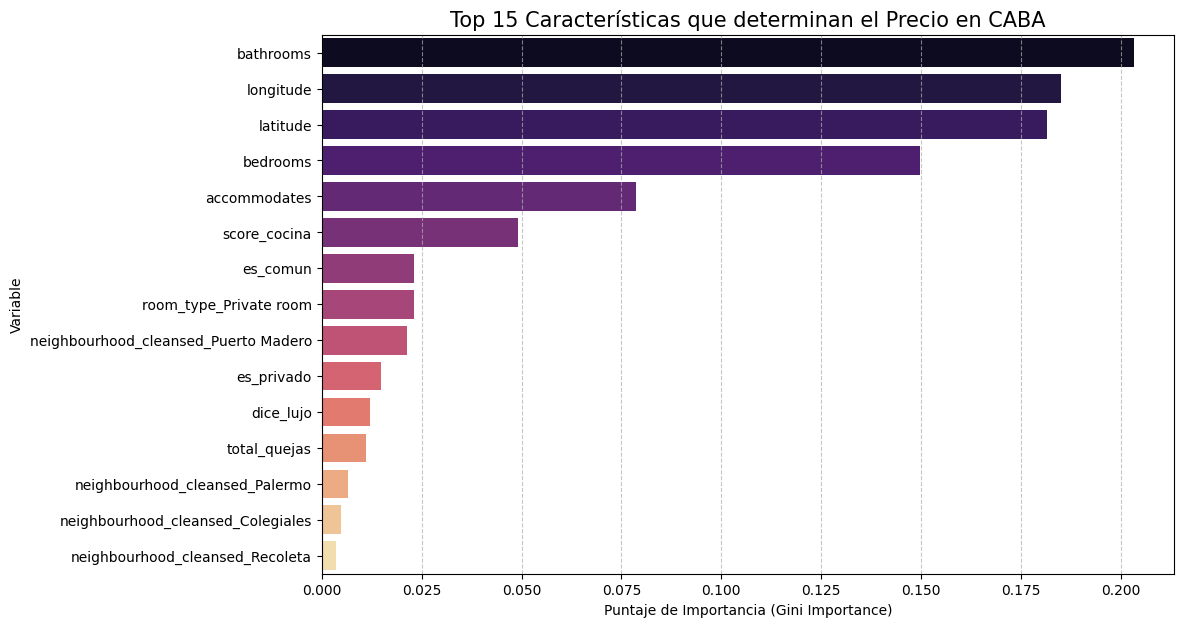

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extraer las importancias del modelo entrenado
importancias = modelo.feature_importances_
nombres_columnas = X.columns

# 2. Crear un DataFrame para facilitar la visualización
df_importancia = pd.DataFrame({'Característica': nombres_columnas, 'Importancia': importancias})
df_importancia = df_importancia.sort_values(by='Importancia', ascending=False).head(15) # Top 15

# 3. Graficar
plt.figure(figsize=(11, 7))
sns.barplot(x='Importancia', y='Característica', data=df_importancia, palette='magma')
plt.title('Top 15 Características que determinan el Precio en CABA', fontsize=15)
plt.xlabel('Puntaje de Importancia (Gini Importance)')
plt.ylabel('Variable')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

3.11. Gráfico de Residuos

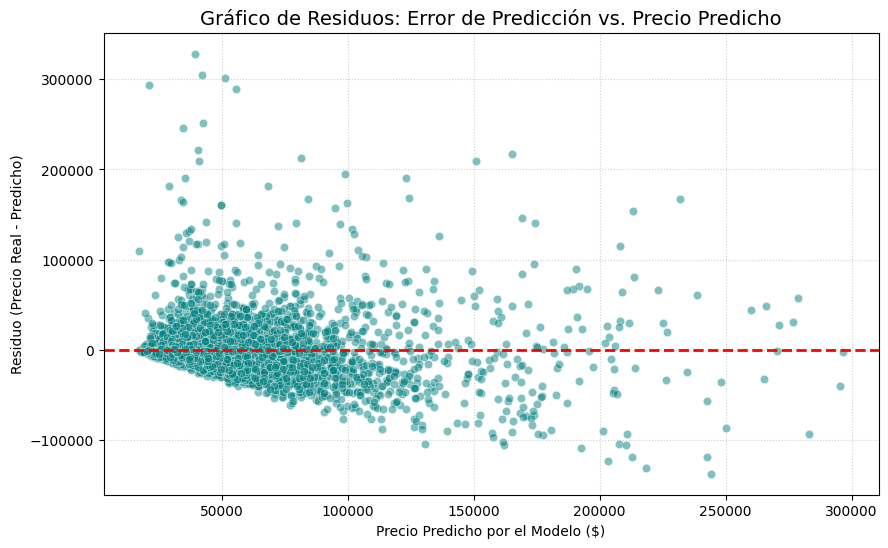

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculamos los residuos
residuos = y_test - predicciones

# 2. Creamos el gráfico
plt.figure(figsize=(10, 6))
sns.scatterplot(x=predicciones, y=residuos, alpha=0.5, color='teal')

# Añadimos una línea horizontal en cero (donde el error sería inexistente)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

plt.title('Gráfico de Residuos: Error de Predicción vs. Precio Predicho', fontsize=14)
plt.xlabel('Precio Predicho por el Modelo ($)')
plt.ylabel('Residuo (Precio Real - Predicho)')
plt.grid(True, linestyle=':', alpha=0.6)

plt.show()

3.12. Guardamos el df_final en formato .csv en drive

In [31]:
# 1. Nos aseguramos de que el Drive esté montado
from google.colab import drive
drive.mount('/content/drive')

# 2. Guardamos el DataFrame final
# Usamos index=False para que no cree una columna extra de números innecesaria
ruta_guardado = '/content/drive/MyDrive/airbnb_ba_modelo_final.csv'
df_final.to_csv(ruta_guardado, index=False)

print(f"✅ ¡Éxito! El archivo se guardó en: {ruta_guardado}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ ¡Éxito! El archivo se guardó en: /content/drive/MyDrive/airbnb_ba_modelo_final.csv


Conclusiones Finales

El análisis integral de los datos de Airbnb en CABA permitió extraer las siguientes conclusiones clave:

Determinantes del Precio:

El modelo de Random Forest identificó que la infraestructura básica (baños y dormitorios) y la ubicación geográfica precisa (latitud/longitud) tienen un impacto significativamente mayor en el precio que las etiquetas de marketing ("lujo") o el barrio general. Sorprendentemente, el equipamiento de la cocina (score_cocina) resultó ser un predictor más sólido que los amenities comunes del edificio.

Detección de Especulación:

El uso del modelo como herramienta de auditoría permitió identificar propiedades con precios hasta un 800% por encima de su valor estimado. Estas anomalías suelen coincidir con anuncios de "precios placeholder" o intentos de capitalizar eventos estacionales, demostrando que el precio publicado no siempre refleja el valor real de mercado.

Fiabilidad del Modelo:

Con un R^2 de 0.49, el modelo es altamente confiable para tasar hospedajes en el rango de $40,000 a $120,000. El gráfico de residuos muestra que la precisión disminuye en propiedades de alto valor, sugiriendo que el segmento de lujo se rige por variables subjetivas o dinámicas de precios que exceden la información técnica del anuncio.

Impacto de las Reseñas:

La integración de un análisis de sentimientos y conteo de quejas permitió "castigar" la valoración de propiedades en barrios con alta rotación (como Palermo), revelando que un alto volumen de quejas por falta de veracidad es un indicador crítico de sobreprecio.